In [1]:
import os, sys
from pathlib import Path

src_path = Path(os.getcwd()).resolve().parents[1]  
sys.path.append(str(src_path))

print(sys.path[-1])  
import os
print(os.getcwd())

/Users/seobi/PythonProjects/RAG_Commander/src
/Users/seobi/PythonProjects/RAG_Commander/src/agents/main


In [2]:
%%writefile main_agent.py
from langchain_openai import ChatOpenAI
from langgraph.graph.state import Command, Literal
from agents.state.start_state import StartConfirmation, StartInput
from agents.state.main_state import MainState
from utils.llm import LLMProfile
from utils.util import get_today_str
from langchain_core.messages import HumanMessage, get_buffer_string, AIMessage
from langgraph.graph import StateGraph, START, END
from prompts import PromptManager, PromptType
from agents.analysis.analysis_graph import analysis_graph
from agents.jung_min_jae.jung_min_jae_agent import report_graph
from copy import deepcopy

start_llm = ChatOpenAI(model=LLMProfile.START_COMFIRMATION, temperature=0)
messages_key = MainState.KEY.messages
start_input_key = MainState.KEY.start_input
analysis_outputs_key = MainState.KEY.analysis_outputs
status_key = MainState.KEY.status


def start_confirmation(
    state: MainState,
) -> Command[Literal["start", "__end__"]]:

    parser_llm = start_llm.with_structured_output(StartConfirmation)
    messages_str = get_buffer_string(messages=state[messages_key])

    prompt = PromptManager(PromptType.MAIN_START_CONFIRMATION).get_prompt(
        messages=messages_str
    )
    response: StartConfirmation = parser_llm.invoke([HumanMessage(content=prompt)])

    if response.confirm == False:
        return Command(
            goto=END, update={messages_key: [AIMessage(content=response.question)]}
        )
    else:
        return Command(
            goto="start",
            update={messages_key: [AIMessage(content=response.verification)]},
        )


def start(state: MainState) -> MainState:
    parser_model = start_llm.with_structured_output(StartInput)
    prompt = PromptManager(PromptType.MAIN_START).get_prompt(
        messages=get_buffer_string(state[messages_key]), date=get_today_str()
    )
    response: StartInput = parser_model.invoke([HumanMessage(content=prompt)])
    return {start_input_key: response.model_dump(), status_key: "ANALYSIS"}


def analysis_graph_node(state: MainState) -> MainState:
    result = analysis_graph.invoke({"start_input": deepcopy(state[start_input_key])})
    return {
        "analysis_outputs": result.get("analysis_outputs", {}),
        status_key: "JUNG_MIN_JAE"
    }


def jung_min_jae_graph(state: MainState) -> MainState:
    result = report_graph.invoke({"start_input": deepcopy(state[start_input_key]),
                                  "analysis_outputs": deepcopy(state[analysis_outputs_key])})
    return {
        "final_report": result["final_report"],
        status_key:"RENDERING"
    }


graph_builder = StateGraph(MainState)

start_confirmation_key = "start_confirmation"
start_key = "start"
analysis_graph_key = "analysis_graph"
jung_min_jae_key = "jung_min_jae_graph"

graph_builder.add_node(start_confirmation_key, start_confirmation)
graph_builder.add_node(start_key, start)
graph_builder.add_node(analysis_graph_key, analysis_graph_node)
graph_builder.add_node(jung_min_jae_key, jung_min_jae_graph)

graph_builder.add_edge(START, start_confirmation_key)
graph_builder.add_edge(start_key, analysis_graph_key)
graph_builder.add_edge(analysis_graph_key, jung_min_jae_key)
graph_builder.add_edge(analysis_graph_key, END)


Overwriting main_agent.py


/Users/seobi/PythonProjects/RAG_Commander/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


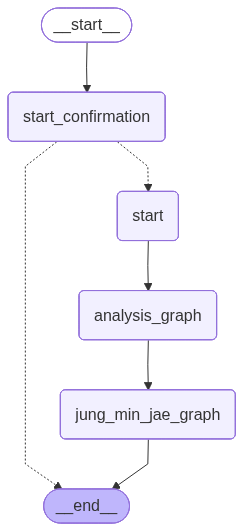

In [3]:
from main_agent import graph_builder
graph = graph_builder.compile()
graph

In [4]:
from utils.format_message import format_message
from langchain_core.messages import HumanMessage
from langgraph.checkpoint.memory import InMemorySaver
from agents.state.main_state import MainState
messages_key = MainState.KEY.messages
checkpointer = InMemorySaver()
graph = graph_builder.compile(checkpointer = checkpointer)

thread = {"configurable": {"thread_id":"1"}}
result = graph.invoke(
    {
        messages_key : [HumanMessage(content = "경기도 분당구 정자동 백현로 206 근처를 분석하고 싶고 규모는 대단지, 세대수는 1000세대 정도 생각합니다. ")]
    },
    config = thread
)

format_message(result[messages_key])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ 경기도 분당구 정자동 백현로 206 근처를 분석하고 싶고 규모는 대단지, 세대수는 1000세대 정도 생각합니다.          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ 제공해주신 정보(경기도 분당구 정자동 백현로 206 근처, 대단지, 약 1,000세대 규모)를 바탕으로 보고서 작성을       │
│ 시작하겠습니다. 요청하신 위치와 단지 규모, 세대수가 명확히 확인되었습니다. 지금부터 부동산 대행사 사내용        │
│ 보고서를 작성하겠습니다.                                                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [ ]:
result

{'messages': [HumanMessage(content='경기도 분당구 정자동 백현로 206 근처를 분석하고 싶고 규모는 대단지, 세대수는 1000세대 정도 생각합니다. ', additional_kwargs={}, response_metadata={}, id='7cea1a2f-990f-42c6-871d-d321e860335e'),
  AIMessage(content='제공해주신 정보(경기도 분당구 정자동 백현로 206 근처, 대단지, 약 1,000세대 규모)를 바탕으로 보고서 작성을 시작하겠습니다. 요청하신 위치와 단지 규모, 세대수가 명확히 확인되었습니다. 지금부터 부동산 대행사 사내용 보고서를 작성하겠습니다.', additional_kwargs={}, response_metadata={}, id='122a4e1d-5b4f-44ba-9d2d-7ab03eb10df1')],
 'start_input': {'target_area': '경기도 분당구 정자동 백현로 206 근처',
  'scale': '대단지',
  'total_units': 1000,
  'units_by_type': None,
  'brand': None,
  'orientation': None,
  'parking_ratio': None,
  'terrain_condition': None,
  'gross_area': None,
  'floor_area_ratio_range': None,
  'building_coverage_ratio_range': None},
 'analysis_outputs': {'economic_insight': '기준일: 2025-10-26 / 2025-10-26T09:00:00+09:00 (Asia/Seoul)\n대상지: 경기 성남시 분당구 정자동 백현로 206 인근\n\n1) 금리/신용여건\n- 한국은행 기준금리 레벨·추세\n  - 최근 결정: 2.50% 동결(2025-10-23), 2.50% 동결(2025-08-28), 2.75%→2.50% 인하(2025-0

In [6]:
print(result['final_report'])

본 보고서는 부동산 마케팅 협회 리서치센터가 2025-10-26(Asia/Seoul) 기준으로 작성한 공식 종합 리서치 결과입니다. 하위 분석원의 정량·정성 결과를 통합하되, 미확보 데이터는 그대로 명기하고, 가격·수요·리스크 판단은 확보된 사실관계와 교육과정 PDF의 전략 원칙을 연결해 해석했습니다.

0. 표지 요약(Executive Summary)
- 인근 실거래(전용 84㎡급, 2024-10~2025-09) 평단 중위값은 약 5,873만원/3.3㎡이며, 신축 재고 앵커(더샵 분당파크리버 84㎡)는 평단 약 6,020만원/3.3㎡로 확인됩니다. 기준금리 하락(-50bp, 12개월)과 정자권역의 직주·생활 인프라를 고려할 때 실수요 기반 흡수력은 중간 이상일 가능성이 높습니다. [근거: nearby_market, economic_insight]
- 권장 분양가(전용 84㎡ 기준): 평단 5,600~6,100만원/3.3㎡(총액 예시: 약 14.4~15.7억원, 옵션·발코니 확장·취득부대비용 제외). 이는 인근 매매 중위 대비 -5%~+4% 구간으로, 신축 재고 앵커(≈6,020)와의 합리적 격차를 유지합니다. [근거: nearby_market; 교육과정 PDF 가격 로직]
- 분양 가능성: 소형·중소형 중심으로 “보통~보통 상단”, 중대형은 “보통~약함” 범주로 추정됩니다. 금리 하락이 우호적이나, DSR 관리 기조와 저성장(2025년 GDP 0.8~0.9% 전망)이 대형·고가 수요의 레버리지에 제약 요인으로 작용합니다. [근거: economic_insight, population_insight]
- 리스크 핵심: 평단 6,460만원/3.3㎡(+10% 룰 상단) 초과 책정 시 주변 매매 중위 대비 과도한 프리미엄으로 흡수 지연 위험이 높아집니다. 중도금 50~60% 무이자, 계약금 10% 분납 등 체감부담 완화 패키지 도입 시 전환률 개선이 기대됩니다. [근거: nearby_market; 교육과정 PDF 전술]
- 데이터 결손: 입지 실보행 지표(도보/분),